In [263]:
import numpy as np
import importlib
import data_utils
importlib.reload(data_utils)
import pipeline
importlib.reload(pipeline)
import pipelines
importlib.reload(pipelines)
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)
from pipeline import Pipeline

Ради интереса я решил написать свою мини-библиотеку, с помощью которой можно конфигурировать обработку данных и делать красивые визуализации

### Генерация данных

In [264]:
pipe = Pipeline('generate_data')
pipe.generate('X', data_utils.gen_range, beg='_beg', end='_end', interval='_interval', std_noise='_stdx')
pipe.transform('X', 'Y_true', data_utils.transform_feature, func='_func')
pipe.transform('Y_true', 'Y', data_utils.std_noise, std='_stdy')

data = [
    pipe.copy('linear').process(_func=lambda x: x, _beg=-100, _end=100, _interval=10, _stdx=2.5, _stdy=15),
    pipe.copy('power').process(_func=lambda x: x*x + 3 * x + 6, _beg=-10, _end=10, _interval=0.5, _stdx=0.5, _stdy=15),
    pipe.copy('log').process(_func=np.log, _beg=0.001, _end=5, _interval=0.3, _stdx=0.0, _stdy=0.4),
    pipe.copy('sin').process(_func=np.sin, _beg=0, _end=np.pi * 6, _interval=0.4, _stdx=0.0, _stdy=0.1),
]

In [265]:
def draw_data(stats=[]):
    def do_draw_data(ax, p):
        X = p.val('X')
        if len(X.shape) > 1:
            X = np.array(X[:, 0])

        Y = np.array(p.val('Y'))
        Y_true = p.val('Y_true')[:p.val('X').shape[0]]

        ax.plot(X, Y_true, 'r--', label='Y_true')
        ax.scatter(X, Y, label='Y')
        if p.has('Y_pred'):
            ax.plot(X, p.val('Y_pred'), 'g', label='Y_pred')
        if len(stats):
            draw_utils.draw_stats(ax, p, stats)
        
    return do_draw_data

def draw_train_results(title, pipes, metrics=['MSE', "RMSE"], loss=True):
    if loss:
        draws = [draw_data(metrics), draw_utils.draw_metric(["loss"]), draw_utils.draw_compare_stats('W', ['X_W', 'bias'])]
    else:
        draws = [draw_data(metrics), draw_utils.draw_compare_stats('W', ['X', 'bias'])]
    draw_utils.draw_plots(pipes, draws, title=title, max_cols=len(draws))

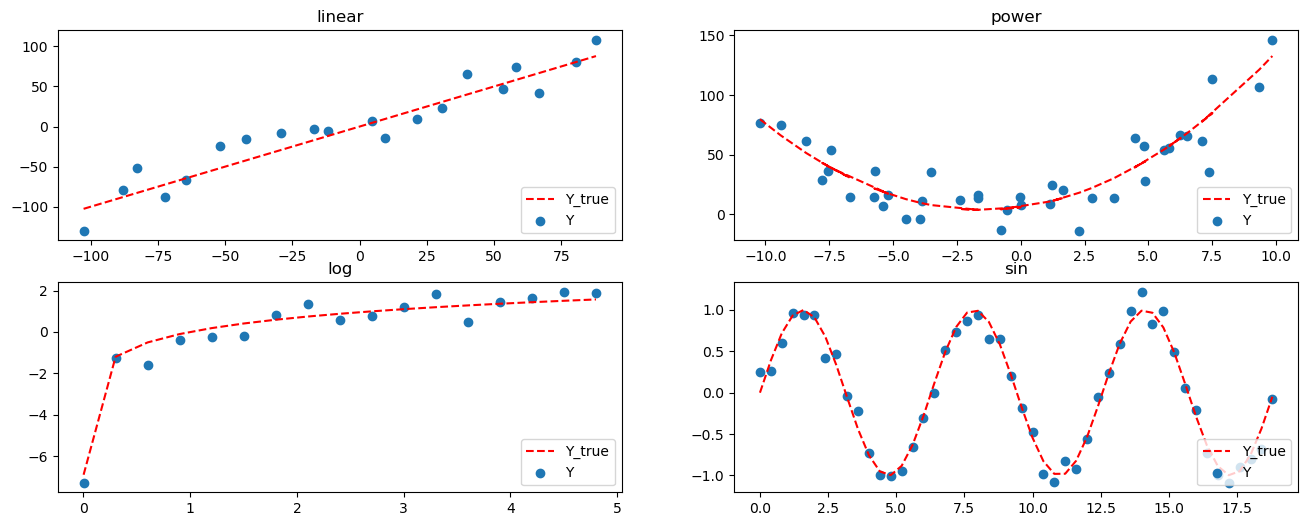

In [266]:
draw_utils.draw_plots(data, draw_data())

### Метод наименьших квадратов

In [267]:
reg_ls = Pipeline('reg_ls')
reg_ls.subpipeline(pipelines.transform_data(['X', 'Y', 'Y_true']))
reg_ls.subpipeline(pipelines.prepare_data())
reg_ls.transform(['X', 'Y'], 'W', linreg_utils.least_squares)
reg_ls.subpipeline(pipelines.predict())
reg_ls.subpipeline(pipelines.metrics())

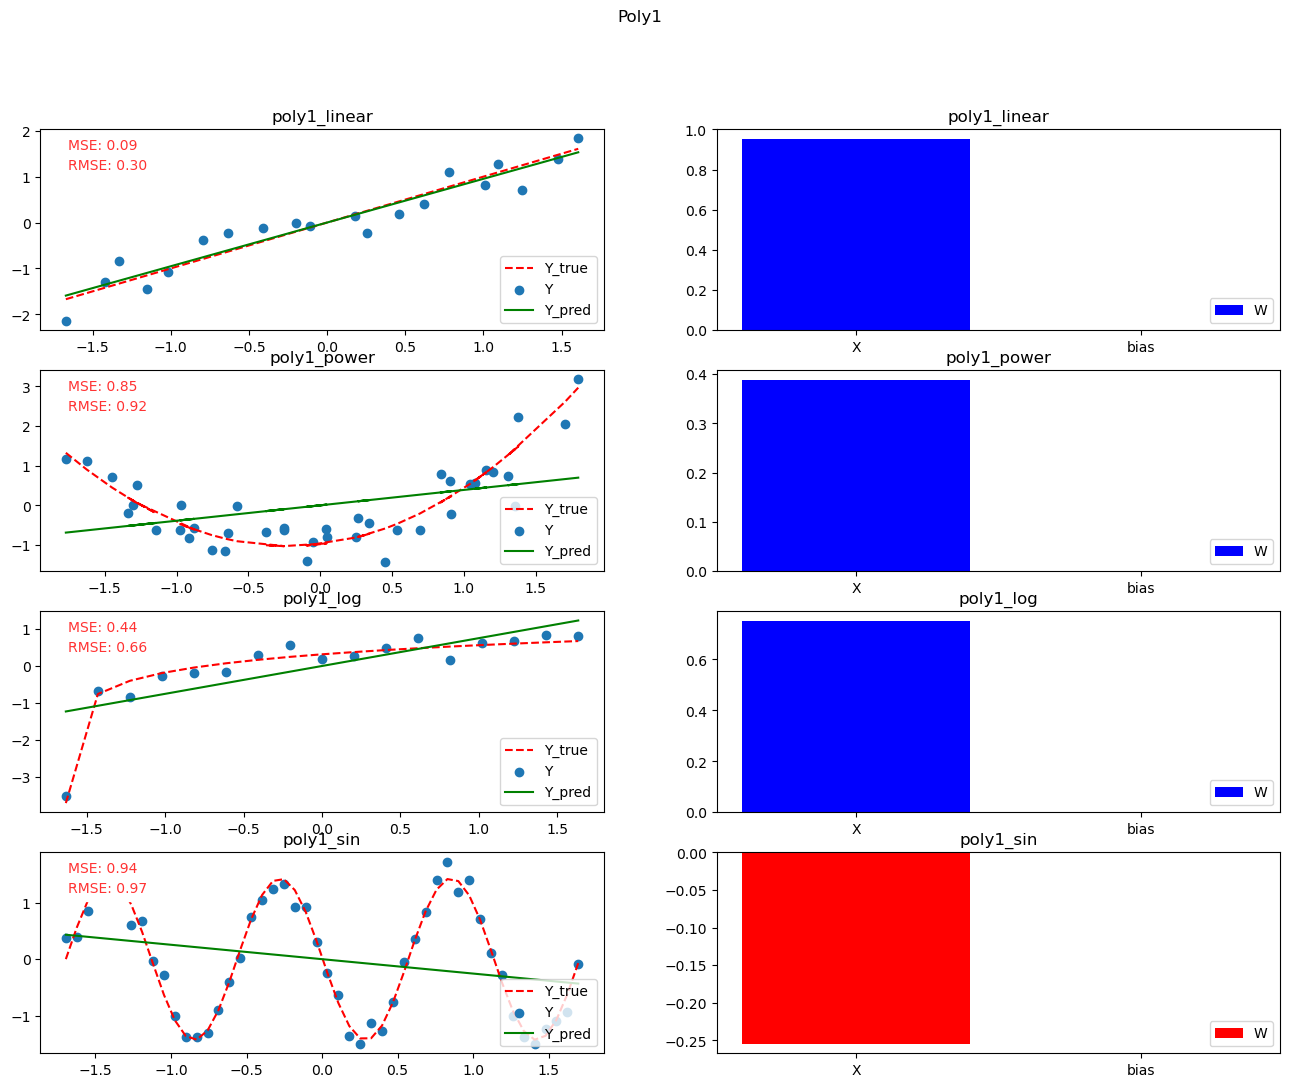

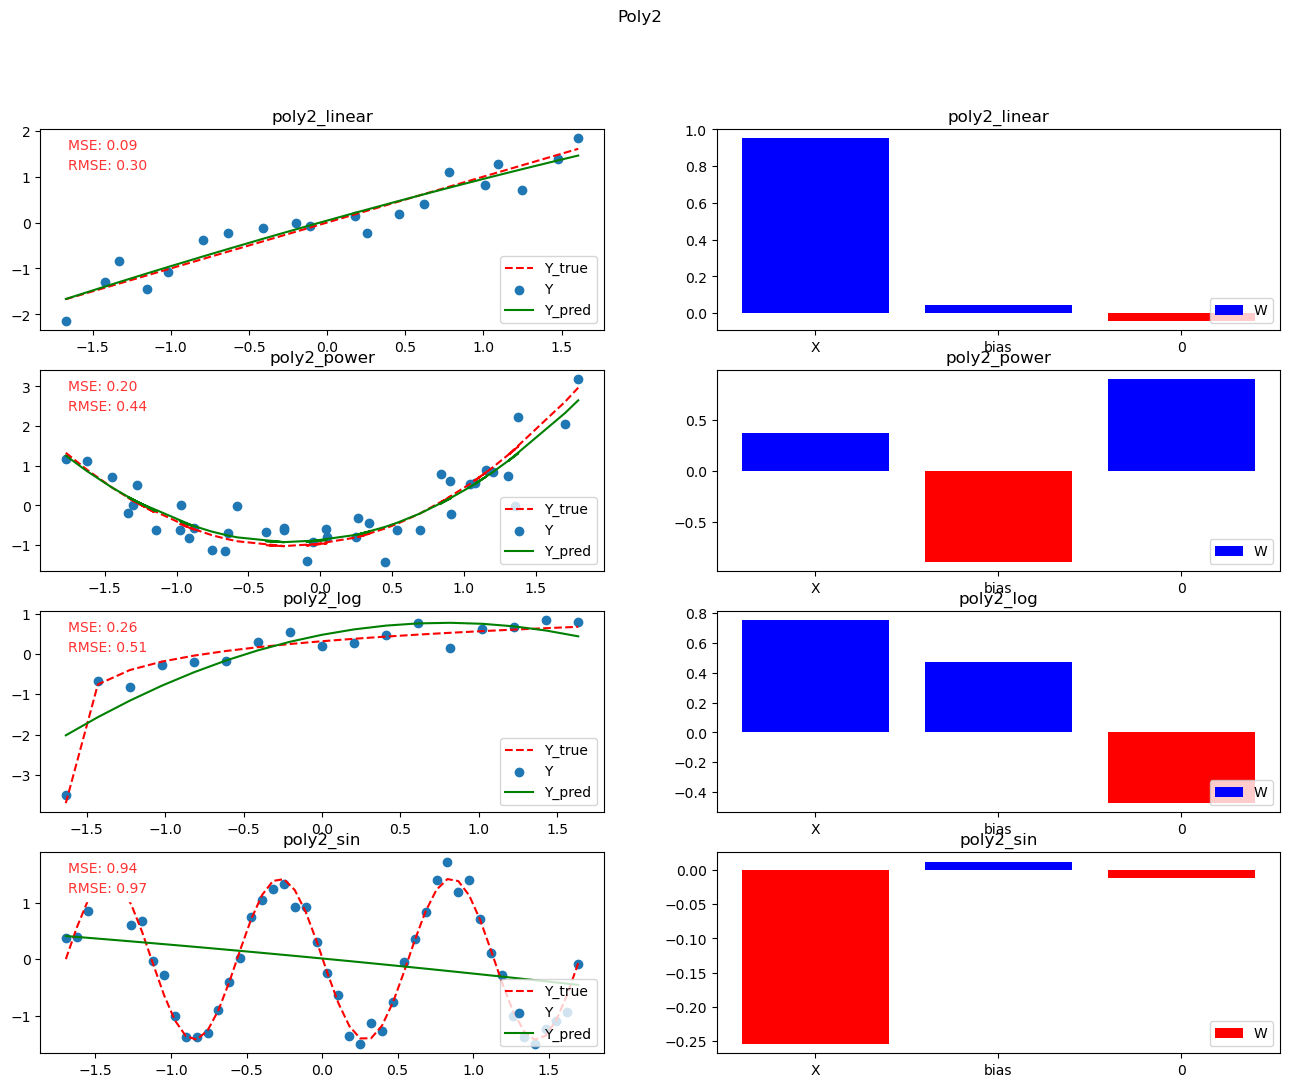

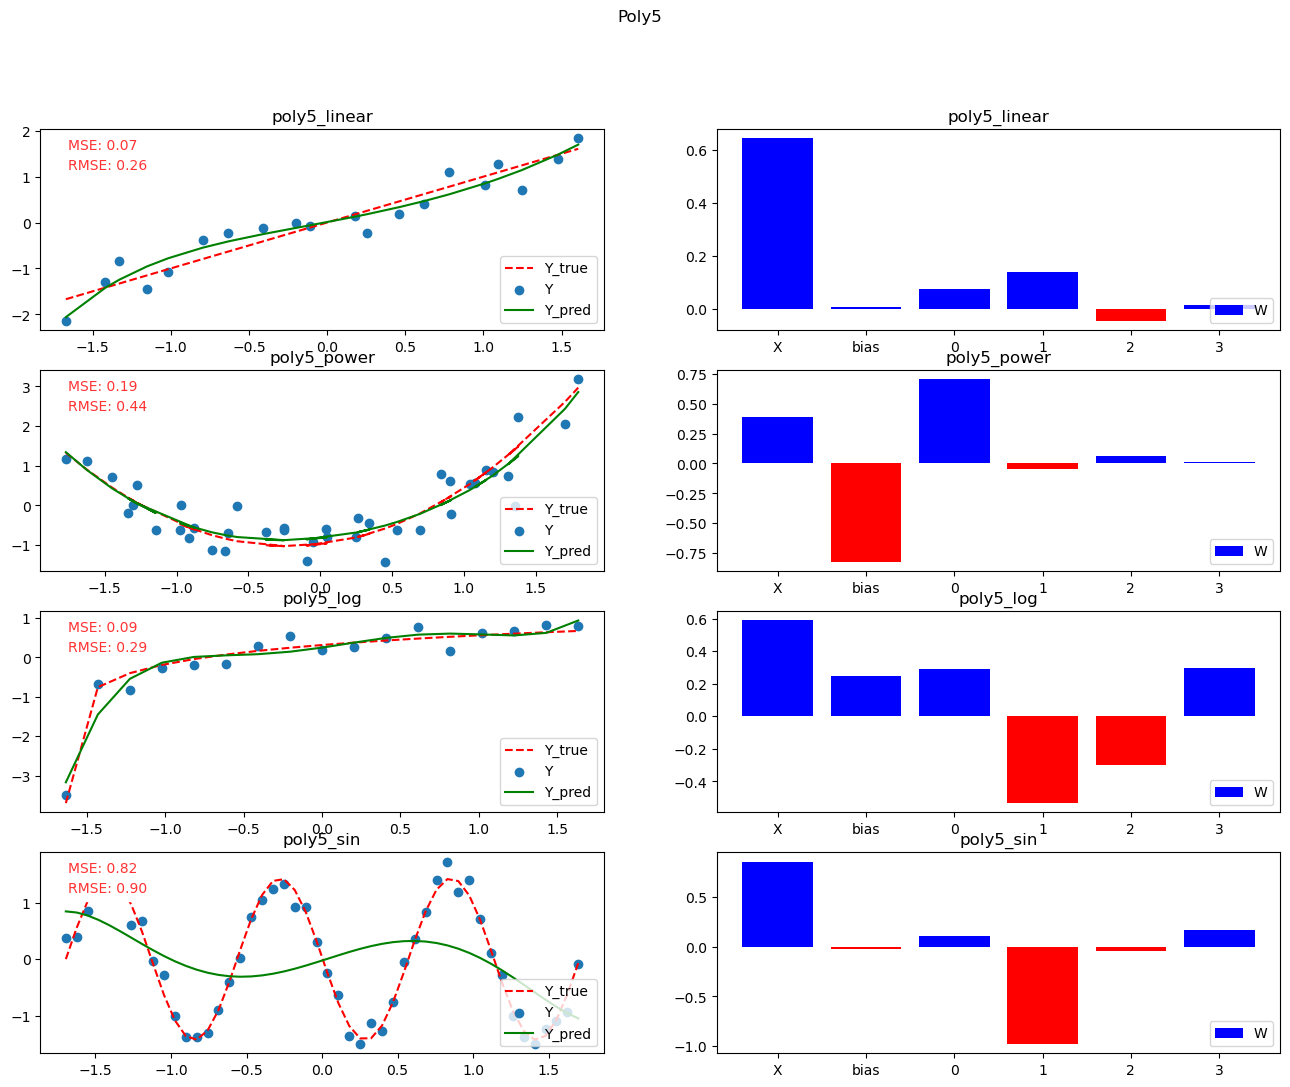

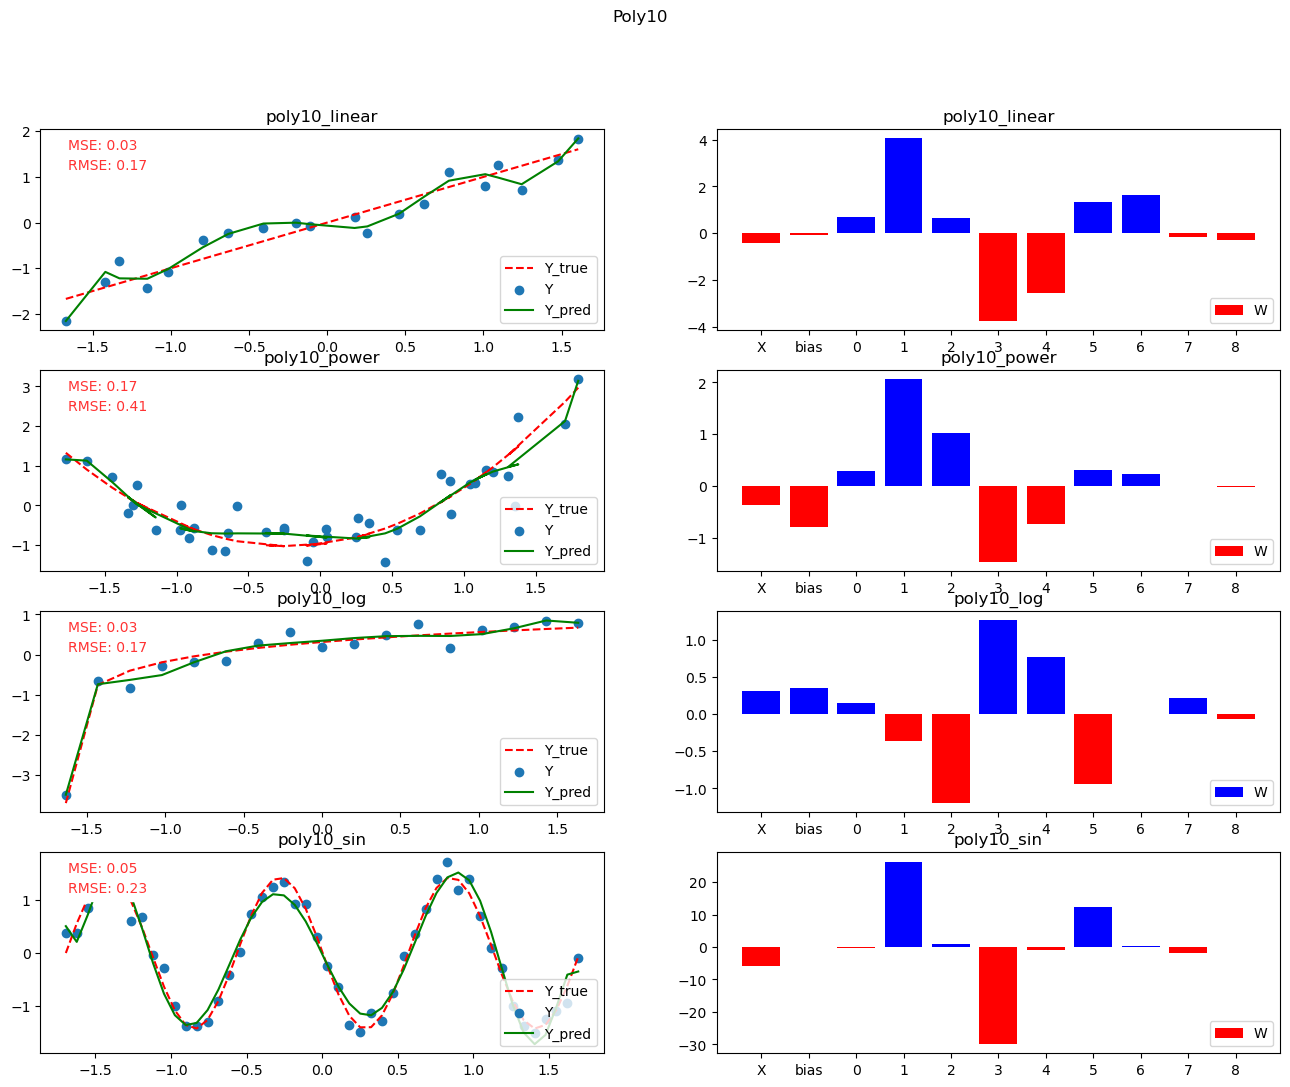

In [268]:
for p in (1, 2, 5, 10):
    pipes = reg_ls.apply_copy('poly' + str(p), data, _std=True, _poly=p, _MSE=True, _RMSE=True)
    draw_train_results('Poly'+str(p), pipes, loss=False)

### Градиентный спуск

In [269]:
reg_gd = Pipeline('reg_gd')
reg_gd.subpipeline(pipelines.transform_data(['X', 'Y', 'Y_true']))
reg_gd.subpipeline(pipelines.prepare_data('X', 'Y'))
reg_gd.subpipeline(pipelines.train_model([pipelines.gradient_descent(), pipelines.regularization()]))
args = {'_std':True, '_batch':10, '_RMSE': True, '_MSE':True, '_loss_MSE':True}

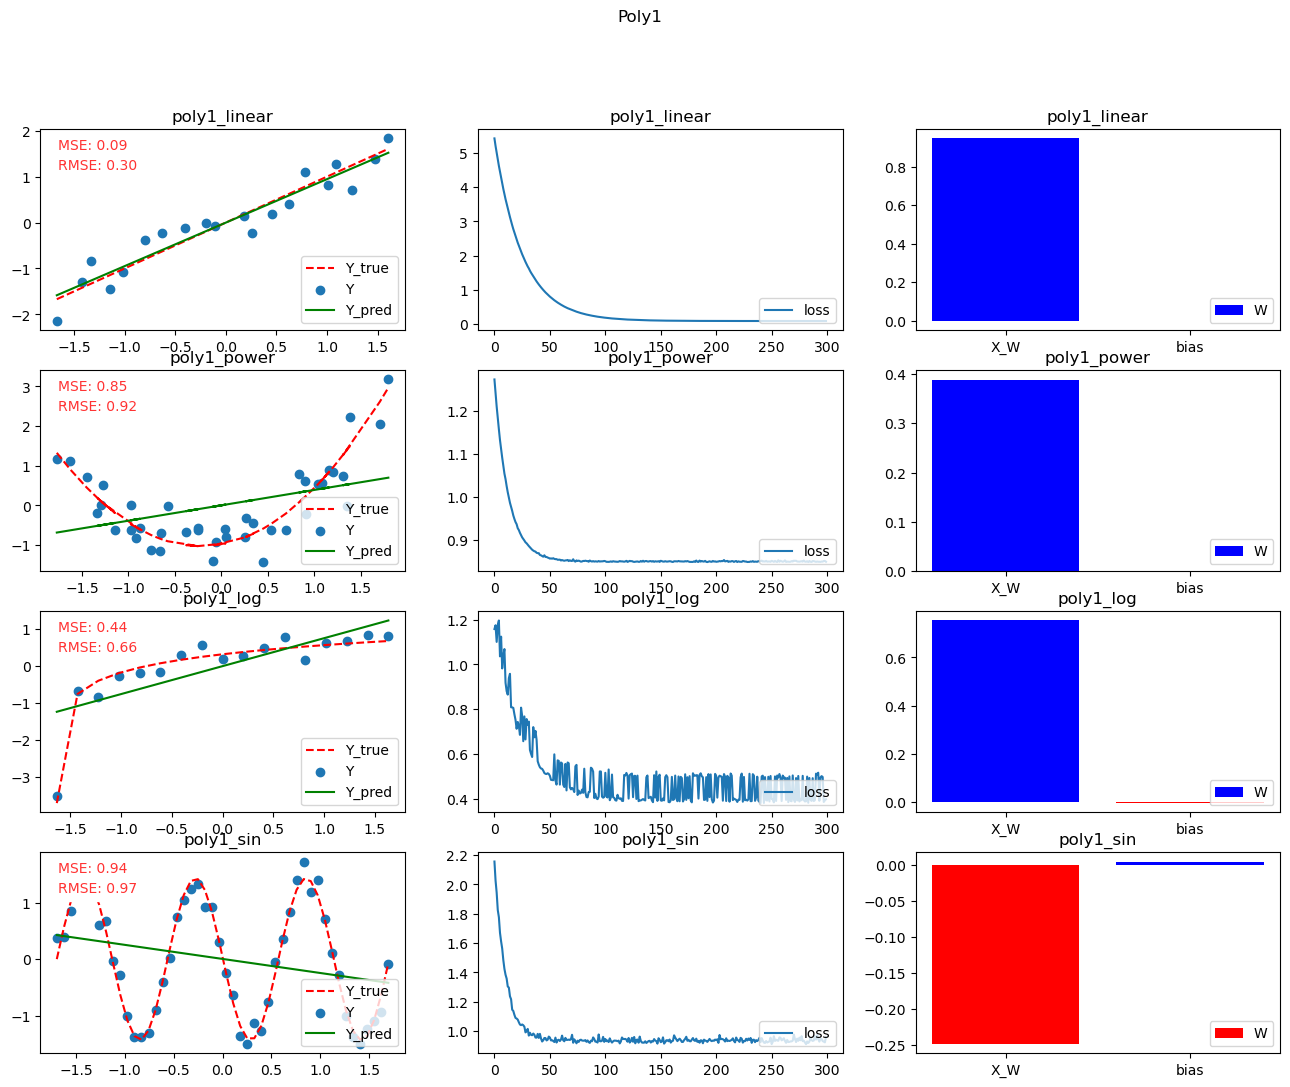

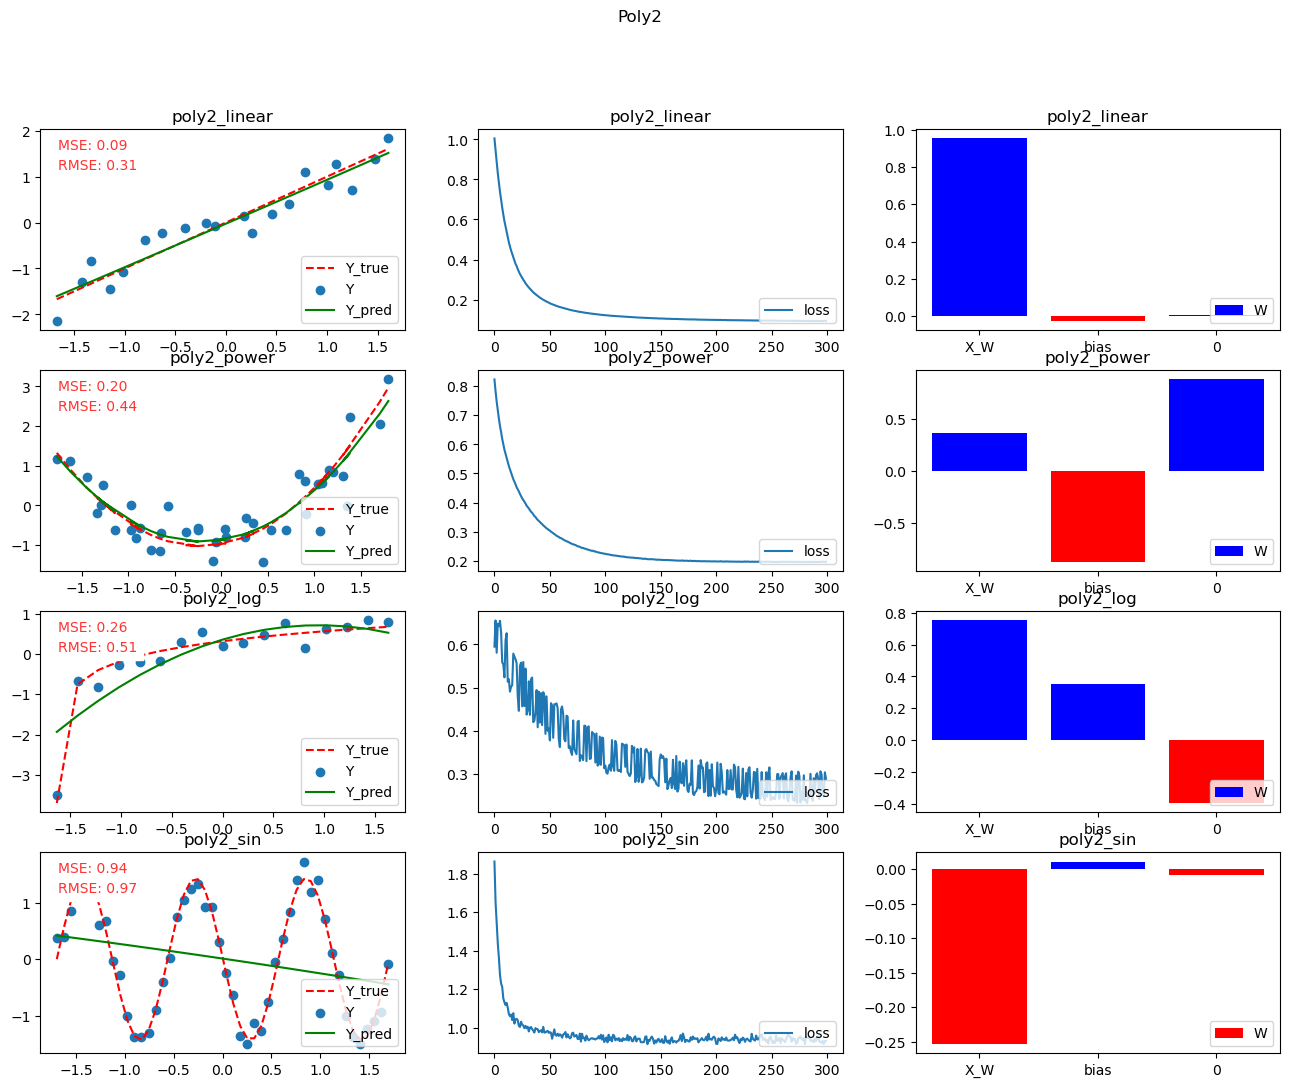

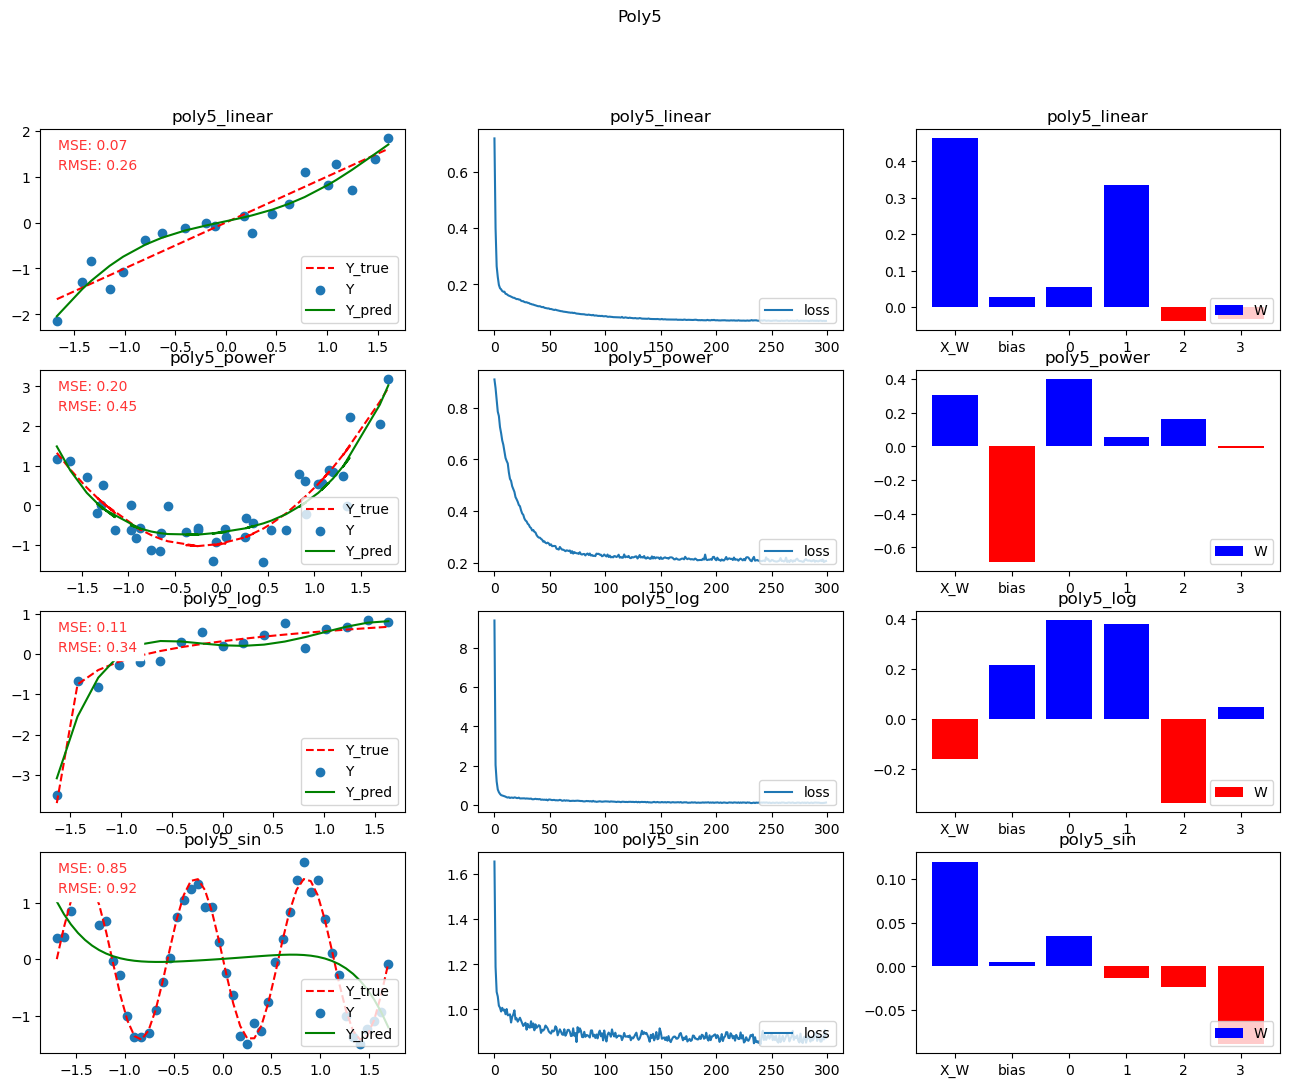

In [270]:
for p in (1, 2, 5):
    pipes = reg_gd.apply_copy('poly' + str(p), data, **args, _poly=p, _epochs=300, _lr=0.01)
    draw_train_results('Poly'+str(p), pipes)

### Градиентный спуск с регуляризацией

#### Lasso регуляризация

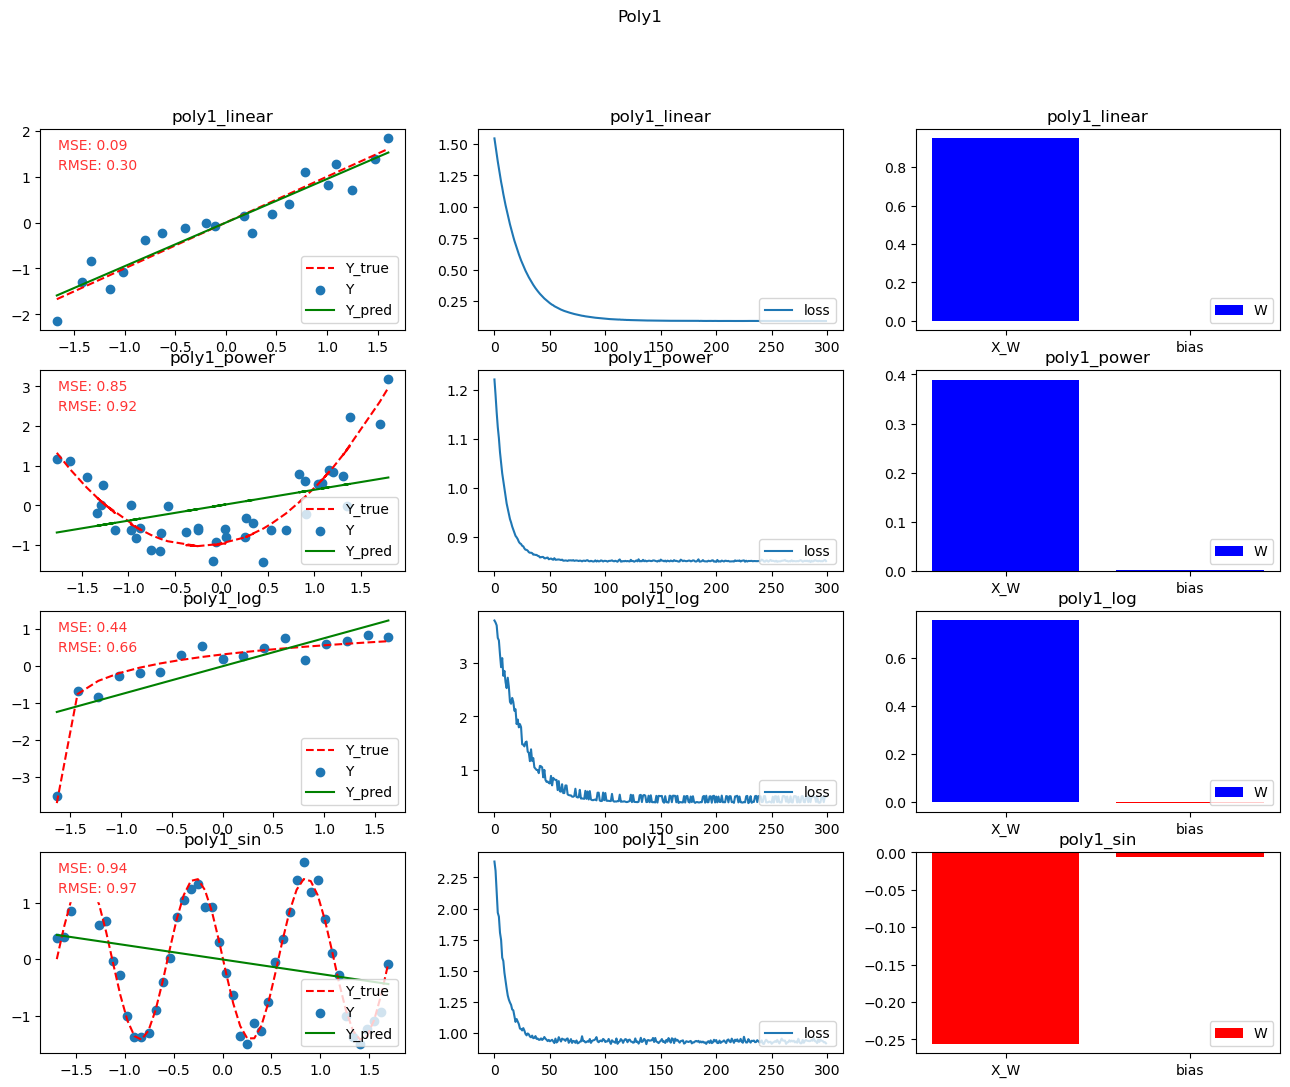

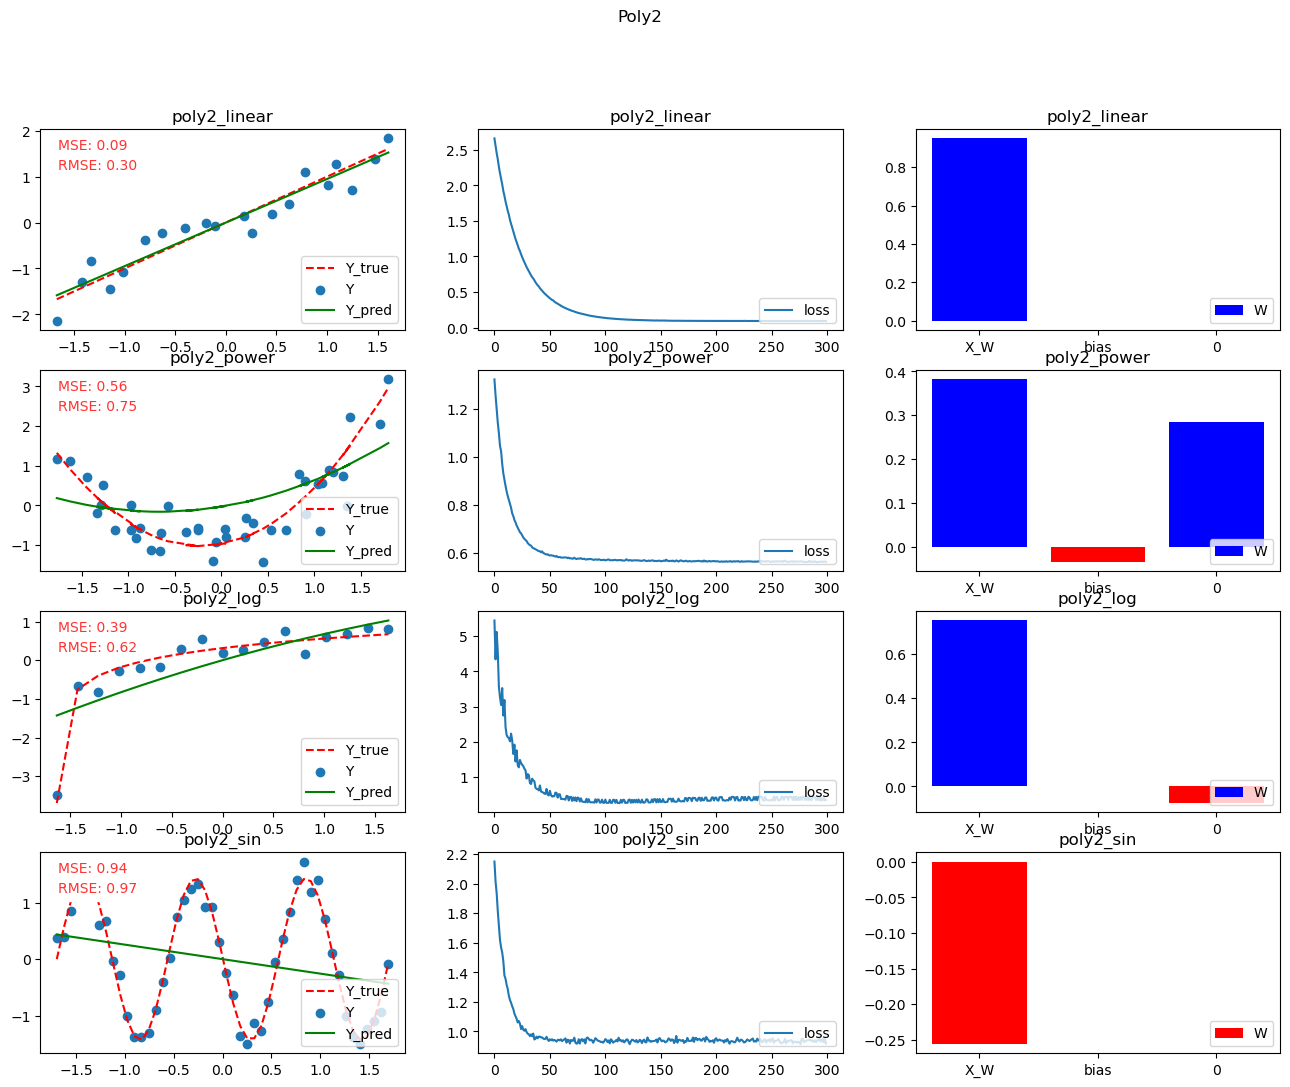

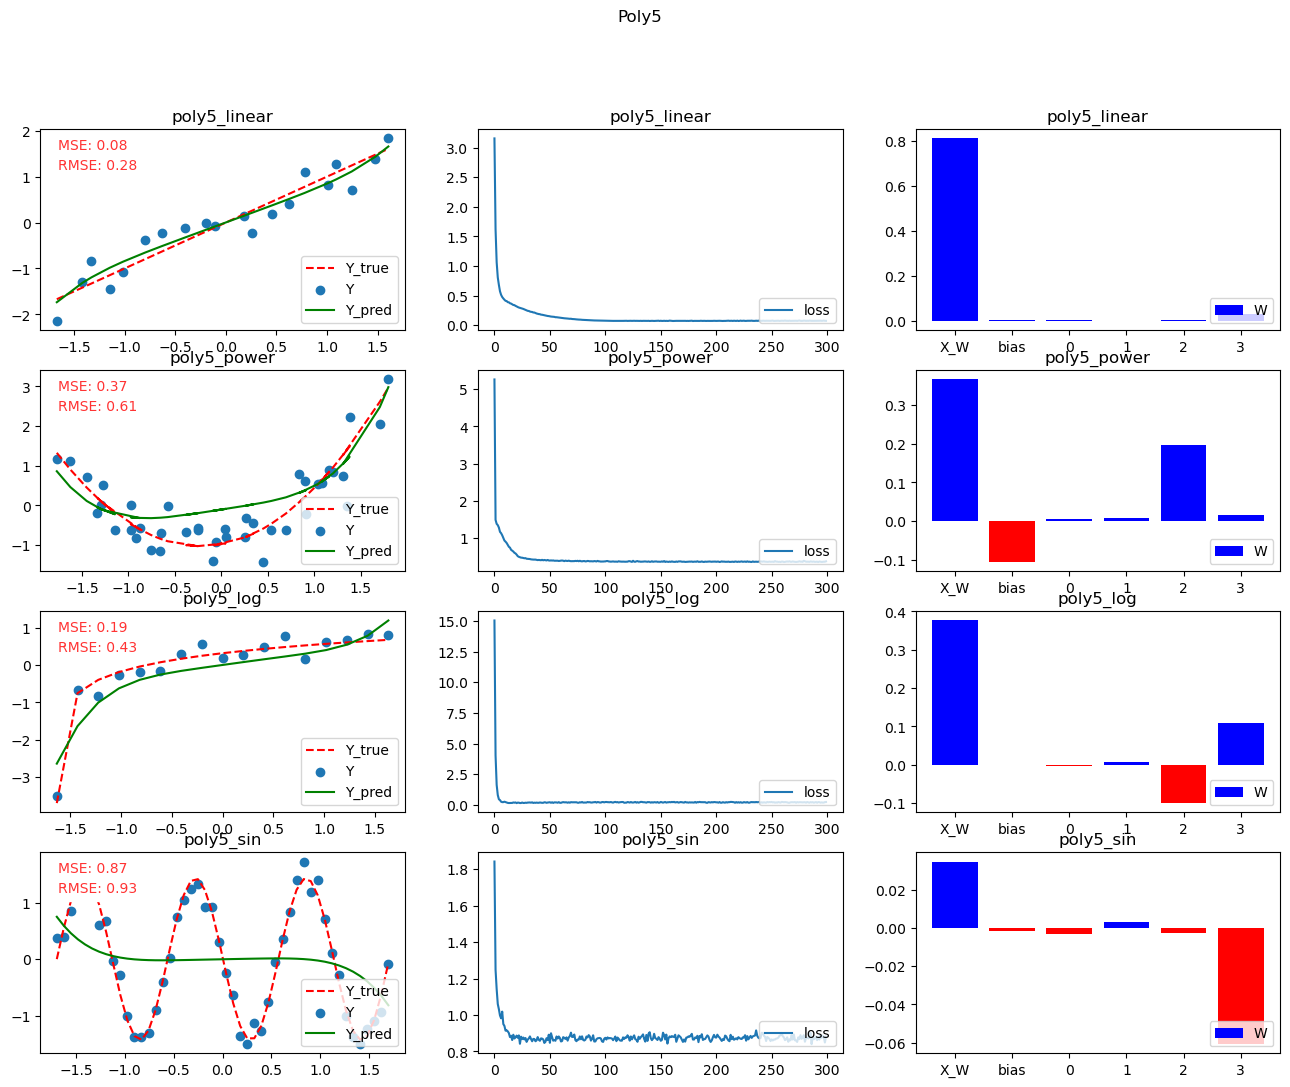

In [271]:
for p in (1, 2, 5):
    pipes = reg_gd.apply_copy('poly' + str(p), data, **args,
        _poly=p, _lasso_l=0.25, _epochs=300, _lr=0.01)
    draw_train_results('Poly'+str(p), pipes)

#### Ridge регуляризация

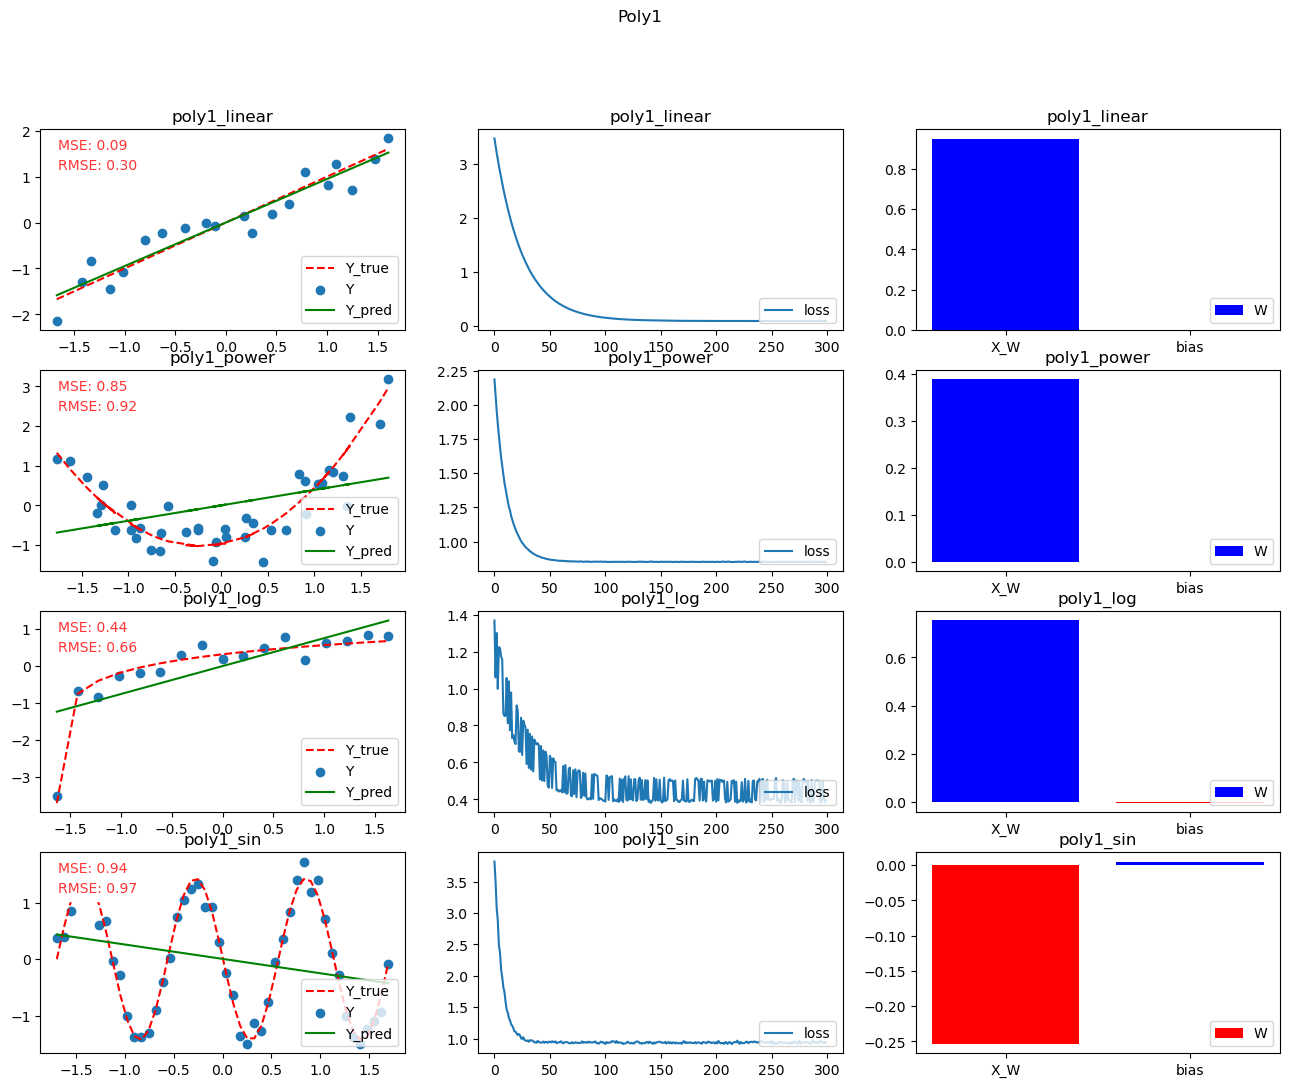

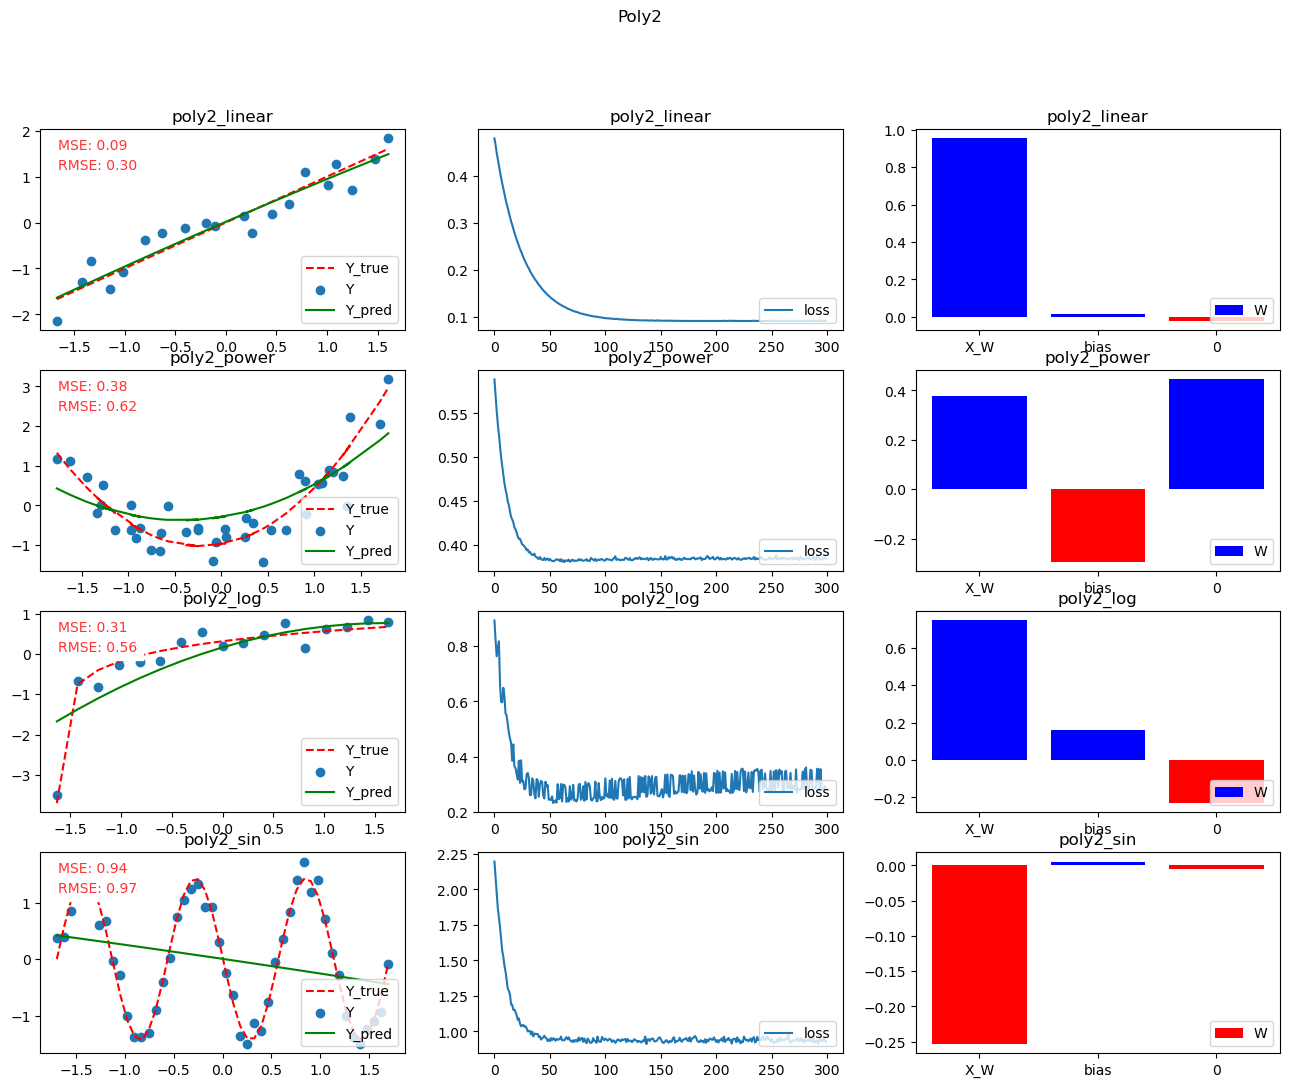

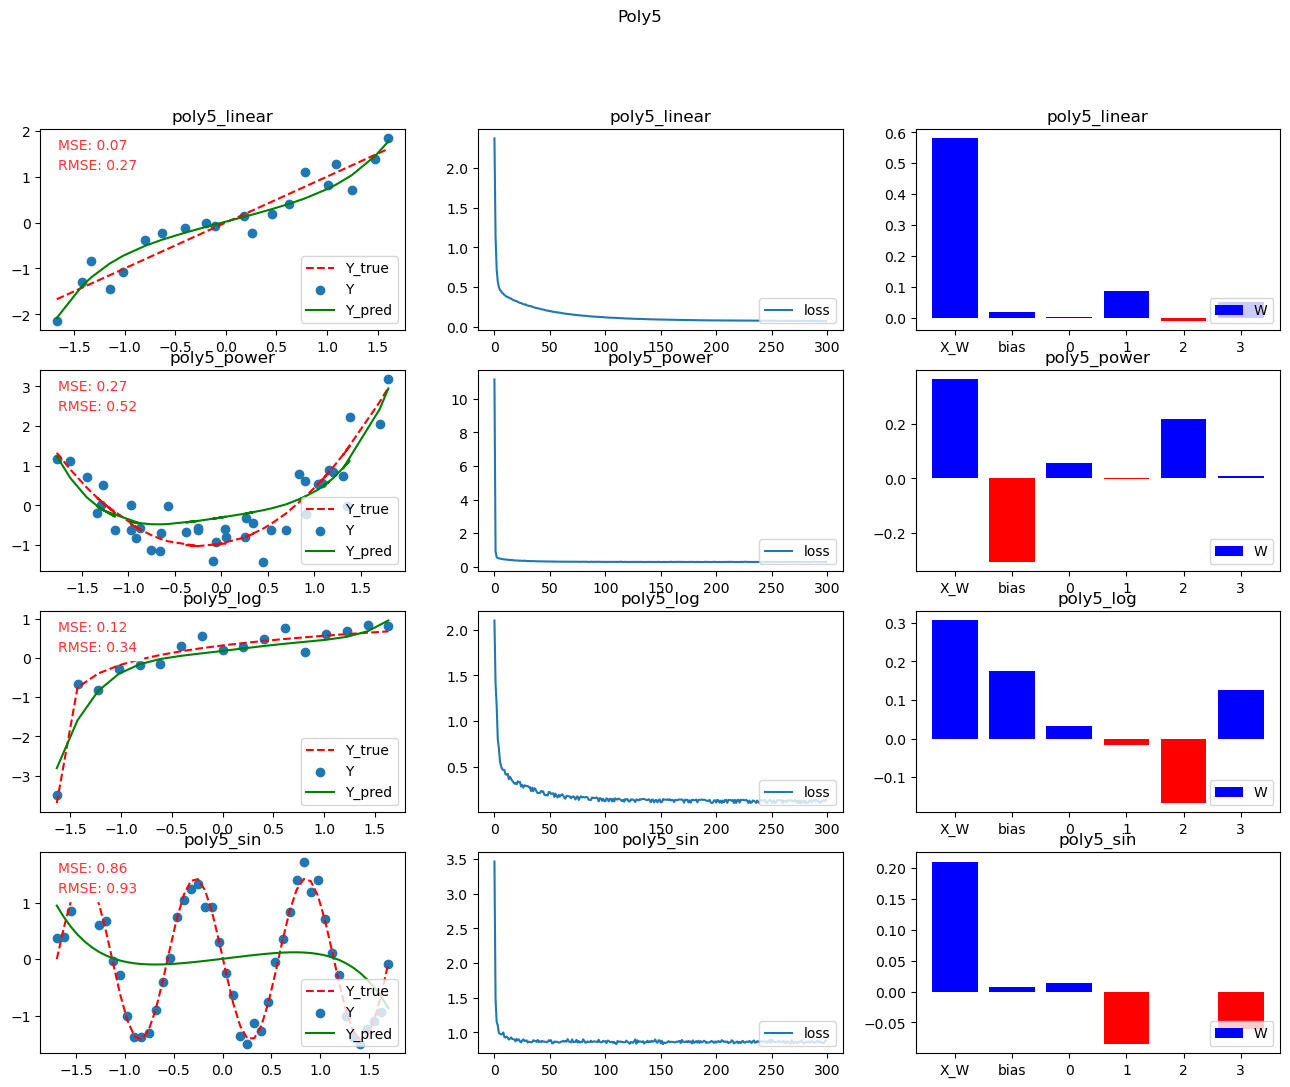

In [272]:
for p in (1, 2, 5):
    pipes = reg_gd.apply_copy('poly' + str(p), data, **args,
        _poly=p, _ridge_l=0.25, _epochs=300, _lr=0.01)
    draw_train_results('Poly'+str(p), pipes)

#### Lasso + Ridge регуляризация

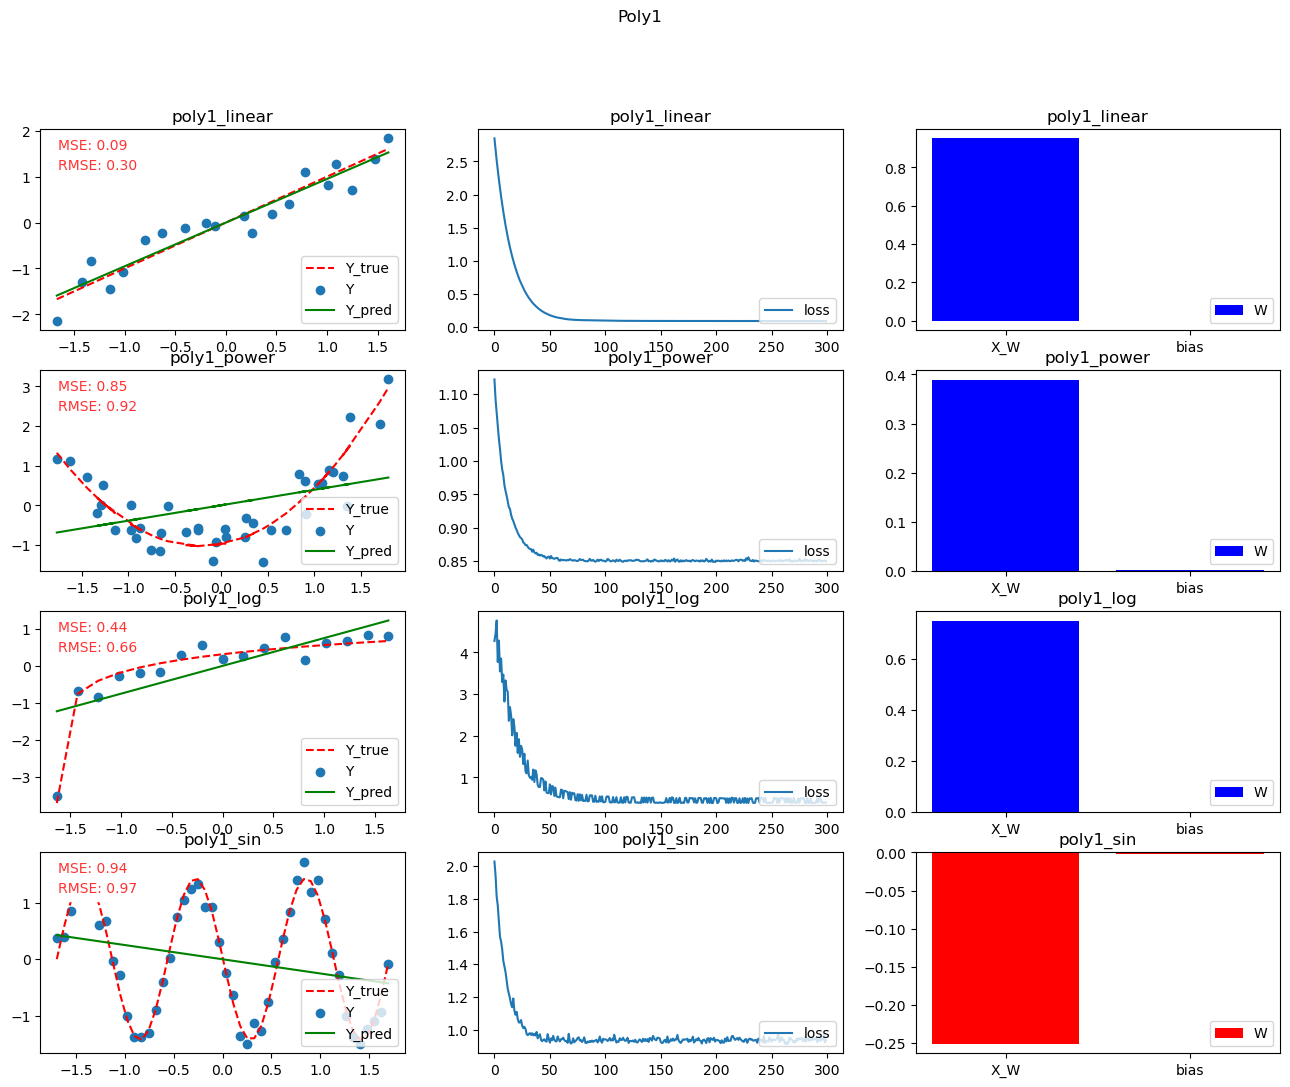

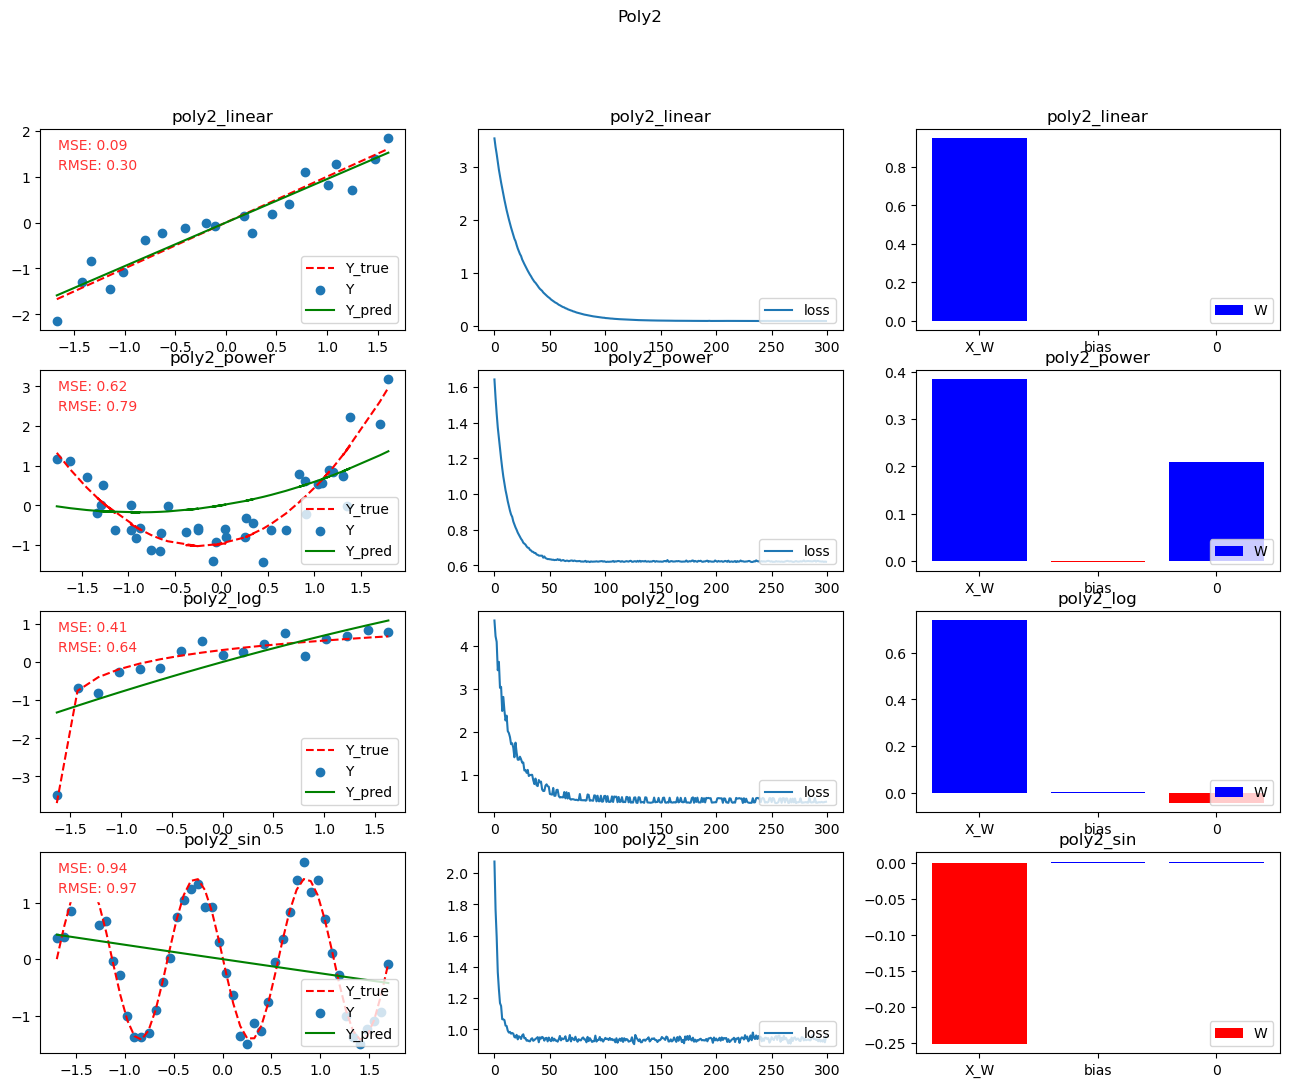

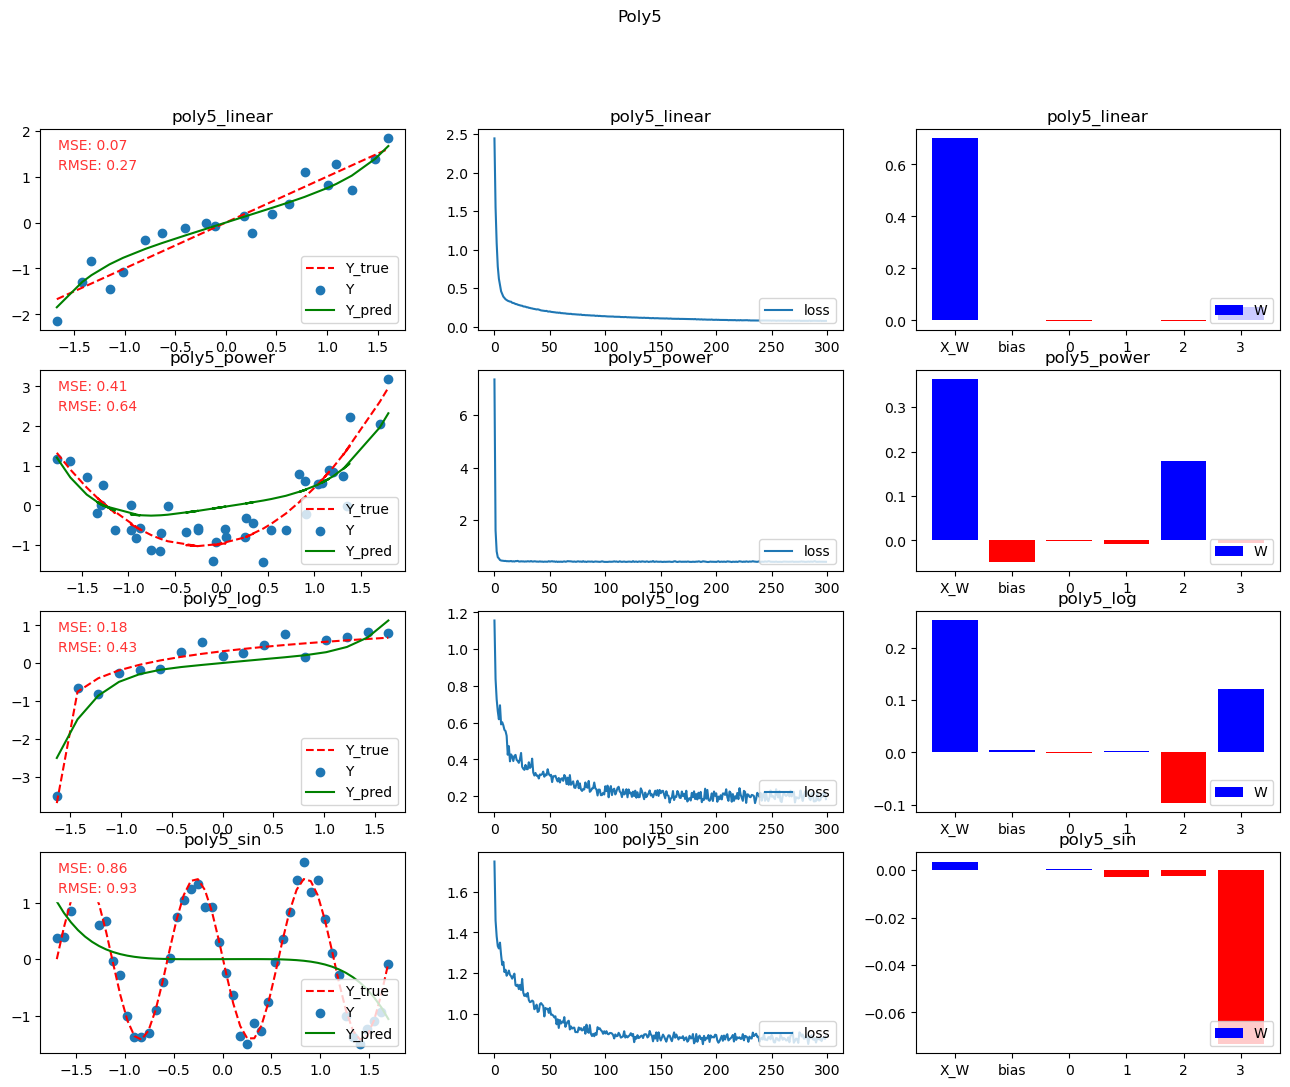

In [273]:
for p in (1, 2, 5):
    pipes = reg_gd.apply_copy('poly' + str(p), data, **args,
        _poly=p, _ridge_l=0.25, _lasso_l=0.25, _epochs=300, _lr=0.01)
    draw_train_results('Poly'+str(p), pipes)